# Logistic Regression with PyTorch Home Assignment 
## Christian Igel, 2023

In the following, we consider an example where 2D data points are classified using logistic regression and the solution is visualized. 

First, an implementation in Scikit-Learn is given.
Then the same is partly implemented using PyTorch.
Your assignment is to fill in the blanks in the PyTorch implementation.

## Reference implementation using Scikit-Learn 

In [1]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

Generate toy data:

In [2]:
m = 4  # Number of classes
d = 2  # Inout dimensionality
train_n = 50  # Training set size
test_n = 25  # Test set size

# Generate data with three classes
X, y = make_classification(n_samples=test_n + train_n, n_features=d, n_informative=d, n_redundant=0, n_repeated=0, n_classes=m, n_clusters_per_class=1, weights=None, flip_y=0.01, class_sep=0.75, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_n, random_state=0)

### Model training and evaluation 
Train and evaluate model:

In [3]:
# Train logistic regression
logreg = LogisticRegression(penalty=None, fit_intercept=True, multi_class='multinomial', solver='lbfgs', random_state=0)
logreg.fit(X_train, y_train);
# Get model parameters
ws = logreg.coef_
bs = logreg.intercept_
# Evaluate model
train_score = logreg.score(X_train, y_train)
test_score = logreg.score(X_test, y_test)
print("Training error:", train_score, "Test error:", test_score)

Training error: 0.76 Test error: 0.72


### Model visualization

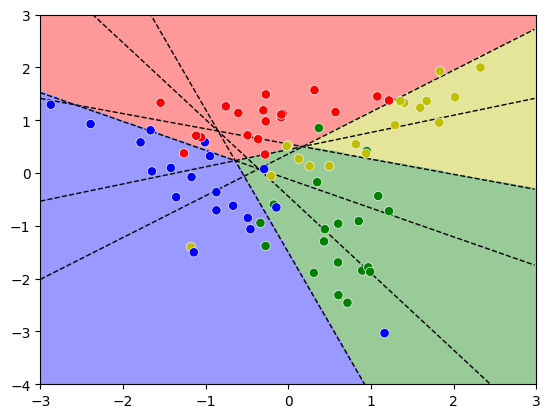

In [4]:
# Colors for the three classes
colors = ['b', 'r', 'g', 'y']
class_colours = [colors[i] for i in y] 
cmap = matplotlib.colors.ListedColormap(colors[:m])

# Compute the plot boundaries
xl, xh = np.floor(X[:,0].min() - 0.1), np.ceil(X[:,0].max() + 0.1) 
yl, yh = np.floor(X[:,1].min() - 0.1), np.ceil(X[:,1].max() + 0.1)
plt.xlim(xl, xh)
plt.ylim(yl, yh)

# Create grid to calculate the decision boundary on
res = (xh-xl)/300  # Resulution of the grid
xx, yy = np.meshgrid(np.arange(xl, xh, res), np.arange(yl, yh, res))

# Make plot
plt.figure(1)
ax = plt.gca()

# Classify each point on the grid
Z = logreg.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

# Plot points
ax.scatter(X[:,0], X[:,1], s=45, c=class_colours, edgecolor=plt.cm.gray(.95), lw=0.5, zorder=100)

# Plot classifications
cax = ax.matshow(Z, cmap=cmap, origin="lower", extent=[xl, xh, yl, yh], aspect="auto", alpha=.4)       
ax.xaxis.set_ticks_position('bottom')
ax.grid(False)

if(m==2):  # Special case 2 classes
    print(ws)
    b = -bs/ws[0,1]
    a = -ws[0,0]/ws[0,1]
    x_line = np.arange(xl, xh, res)
    y_line = a * x_line + b 
    ax.plot(x_line, y_line, 'k', lw=1, ls='--')
else:
    for i in np.arange(m-1):
        for j in np.arange(i+1,m):
            w = ws[i]-ws[j]
            b = bs[i]-bs[j]
            b = -b/w[1]
            a = -w[0]/w[1]
            x_line = np.arange(xl, xh, res)
            y_line = a * x_line + b 
            ax.plot(x_line, y_line, "k", lw=1, ls='--')

plt.xlim(xl, xh)
plt.ylim(yl, yh)
plt.show();

 ## Pytorch
 Now the task is to reproduce the code above using logistic regression implemented in PyTorch.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Model definition
Let's define the logistic regression model as a simpl neural network with a single layer:

In [6]:
class LogisticRegressionPytorch(nn.Module):
    def __init__(self, d, m):
        super(LogisticRegressionPytorch, self).__init__()
        self.linear = nn.Linear(d, m)
    def forward(self, x):
        x = self.linear(x)
        return x

d = 2  # Inout dimensionality
m = 4  # Number of classes
logreg_pytorch = LogisticRegressionPytorch(d, m)
print(logreg_pytorch)

LogisticRegressionPytorch(
  (linear): Linear(in_features=2, out_features=4, bias=True)
)


### Model training and evaluation
First we have to define a loss function. *Double check that output of the network and the expected input of the loss function match!*

In [7]:
optimizer = optim.Adam(logreg_pytorch.parameters(), lr=0.01)
# DEFINITION OF LOSS FUNCTION MISSING
loss_function = nn.CrossEntropyLoss()

In [8]:
no_epochs = 10000  # Number of training steps
X_train_T = torch.Tensor(X_train)
y_train_T = torch.from_numpy(y_train).type(torch.LongTensor)
for epoch in range(no_epochs):  # Loop over the dataset multiple times
    # Zero the parameter gradients
    optimizer.zero_grad()
    # Forward + backward + optimize
    outputs = logreg_pytorch(X_train_T)
    loss = loss_function(outputs, y_train_T)
    loss.backward()
    optimizer.step()

Now the trained model is evaluated:

In [9]:
outputs = logreg_pytorch(X_train_T)
_, predicted = torch.max(outputs.data, 1)
train_correct = (predicted == y_train_T).sum().item()

X_test_T = torch.Tensor(X_test)  # Automatically casts to float
y_test_T = torch.from_numpy(y_test)  # Does not cast to float
outputs = logreg_pytorch(X_test_T)
_, predicted = torch.max(outputs.data, 1)
test_correct = (predicted == y_test_T).sum().item()

print("Training error:", 1-train_correct/len(y_train), "Test error:", 1-test_correct/len(y_test))

Training error: 0.24 Test error: 0.28


### Model visualization
For our visualization, we need the parameters of the model in the followoing format:

In [10]:
print("Weights:", ws, "biases:", bs)

Weights: [[-4.16373945 -3.57826976]
 [-0.01121304  4.02256119]
 [ 1.7507486  -1.39261923]
 [ 2.42420389  0.9483278 ]] biases: [-1.53570138 -0.66166867  1.74417189  0.45319817]


You can get a named list of all parameters of your Pytorch model like this:

In [11]:
for name, param in logreg_pytorch.named_parameters():
    print(name, param.data)

linear.weight tensor([[-3.4137, -4.3518],
        [ 0.7389,  3.2493],
        [ 2.5009, -2.1659],
        [ 3.1744,  0.1750]])
linear.bias tensor([-2.3284, -1.4544,  0.9515, -0.3395])


Now get the parameters as in the format as above.
To convert the trainable tensors to nupy arrays you may want to use `.detach().numpy()`:

In [12]:
ws_torch = logreg_pytorch.linear.weight.detach().numpy()
bs_torch = logreg_pytorch.linear.bias.detach().numpy()

Let's do the plotting.

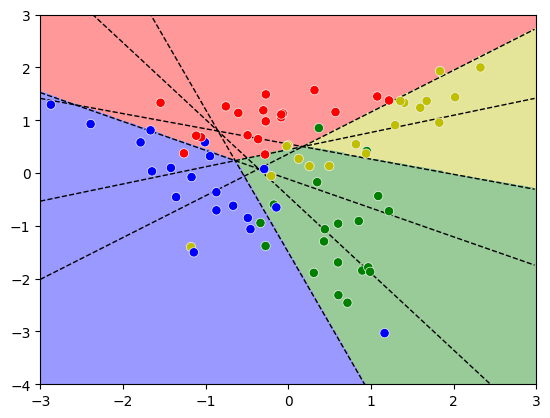

In [13]:
# Make plot
plt.figure(2)
ax = plt.gca()

# Classify each point on the grid
X_Z_T = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])  # Automatically casts to float
outputs = logreg_pytorch(X_Z_T)
_, predicted = torch.max(outputs.data, 1)

Z = predicted.numpy().reshape(xx.shape)

# Plot points
ax.scatter(X[:,0], X[:,1], s=45, c=class_colours, edgecolor=plt.cm.gray(.95), lw=0.5, zorder=100)

# Plot classifications
cax = ax.matshow(Z, cmap=cmap, origin="lower", extent=[xl, xh, yl, yh], aspect="auto", alpha=.4)       
ax.xaxis.set_ticks_position('bottom')
ax.grid(False)

for i in np.arange(m-1):
    for j in np.arange(i+1,m):
        w = ws_torch[i]-ws_torch[j]
        b = bs_torch[i]-bs_torch[j]
        b = -b/w[1]
        a = -w[0]/w[1]
        x_line = np.arange(xl, xh, res)
        y_line = a * x_line + b 
        ax.plot(x_line, y_line, "k", lw=1, ls='--')

plt.xlim(xl, xh)
plt.ylim(yl, yh)
plt.show();